In [2]:
#http://jupyter.org/widgets.html
#http://python-visualization.github.io/folium/docs-master/quickstart.html
#http://folium.readthedocs.io/en/latest/quickstart.html#markers
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame

%matplotlib inline

In [3]:
mpl.__version__, pd.__version__, gpd.__version__

def loadJson(filename):
	import json
	f = open(filename, "r", encoding = "utf-8")
	output = json.load(f)
	f.close()
	return output

In [4]:
# load all geo information
names=['title', 'lon', 'lat']
geodata = pd.read_csv("title_long_lat_2.csv", names=names)
geometry = [Point(xy) for xy in zip(geodata['lon'], geodata['lat'])]



In [5]:
# load event set and remove _
event_set = set([one for one in loadJson("eventList.json")])
event_list = [one for one in loadJson("eventList.json")]
# load people set and remove _
people_set = set([one for one in loadJson("personList.json")])


In [6]:
len(geodata['title'])
print (len([one for one in geodata['title'] if one in event_set]))

print (len([one for one in geodata['title'] if one in people_set]))
for one in people_set:
    print (one)
    break


336
519
Teresa_Gazitúa


In [7]:
event_geodata = geodata[geodata['title'].isin(event_set)]
event_geometry = [Point(xy) for xy in zip(event_geodata['lon'], event_geodata['lat'])]
people_geodata = geodata[geodata['title'].isin(people_set)]
people_geometry = [Point(xy) for xy in zip(people_geodata['lon'], people_geodata['lat'])]
other_geodata = geodata[~geodata['title'].isin(event_set)]
other_geodata = other_geodata[~geodata['title'].isin(people_set)]
other_geometry = [Point(xy) for xy in zip(other_geodata['lon'], other_geodata['lat'])]

print(len(geodata))
print (len(event_geodata))
print (len(people_geodata))
print (len(other_geodata))


/Users/yqh/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


578540
336
519
577685


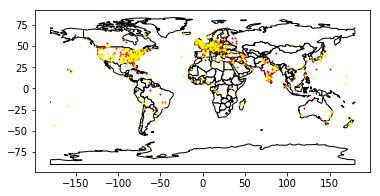

In [8]:
#geometry = [Point(xy) for xy in zip(event_geodate['lon'], event_geodate['lat'])]

#print(len(geometry))
event_gdf = GeoDataFrame(event_geodata, geometry=event_geometry)
people_gdf = GeoDataFrame(people_geodata, geometry=people_geometry)
other_gdf = GeoDataFrame(other_geodata, geometry=other_geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots()
ax.set_aspect('equal')

world.plot(ax=ax, color='white', edgecolor='black')
event_gdf.plot(ax=ax, marker='o', color='red',markersize=1)
people_plot = people_gdf.plot(ax=ax, marker='o', color='yellow',markersize=1)

#other_gdf.plot(ax=ax, marker='o', color='blue',markersize=1)
plt.show()
#plt.savefig("worldmap.png")

In [69]:
def f(x):
    return x
interact(f, x=widgets.IntSlider(min=-10,max=30,step=1,value=10));

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

In [71]:
def f(x):
    return x
interact(f, x=['orange','apple'])

interactive(children=(Dropdown(description='x', options=('orange', 'apple'), value='orange'), Output()), _dom_classes=('widget-interact',))

<function __main__.f>

In [ ]:
# generate checkbox
def f(x):
    return x
interact(f, x=True)

In [73]:
from IPython.display import display
def f(a, b):
    display(a + b)
    return a+b
w = interactive(f, a=10,b=20)
display(w)

interactive(children=(IntSlider(value=10, description='a', max=30, min=-10), IntSlider(value=20, description='b', max=60, min=-20), Output()), _dom_classes=('widget-interact',))

In [81]:
widgets.Checkbox(
    value=False,
    description='People',
    disabled=False
)
cb_event = widgets.Checkbox(
    value=False,
    description='Events',
    disabled=False
)
# cb_other = widgets.Checkbox(
#     value=False,
#     description='Others',
#     disabled=False
# )

In [82]:



tab_contents = ["OL","MPQA","LIWC"]
children = [widgets.Image() for name in tab_contents]
tab = widgets.Tab()
tab.children = children
for i in range(len(children)):
    tab.set_title(i, tab_contents[i])
tab

Tab(children=(Image(value=b''), Image(value=b''), Image(value=b'')), _titles={'0': 'OL', '1': 'MPQA', '2': 'LIWC'})

In [84]:
file = open("worldmap.png", "rb")
image = file.read()
widgets.Image(
    value=image,
    format='png',
    width=300,
    height=400,
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xb0\x00\x00\x01 \x08\x06\x00\x00\x00\xd5(&i\x00\x00\x00\x04sBIT\x08\x08\x08\x08|\x08d\x88\x00\x00\x00\tpHYs\x00\x00\x0b\x12\x00\x00\x0b\x12\x01\xd2\xdd~\xfc\x00\x00 \x00IDATx\x9c\xec\x9dy|T\xd5\xf9\xff?3\x93}!\tI\x88\t!\x0b\x04\x83l\tK\x94\xc5\x02\x95@\xfd"V\x1b\xbe\x80\x05\xadM\xb0\xb5\x16Z\xab\x12\xdcZc\xda~\xb5B\xb1\xbfo\xb5\xf5K\\\xb0jk\xackU\x88\xfb\x86\x12\x8bVPD\x06\x01\x03\xc8>a\r\x90mf\x9e\xdf\x1f\xe7\x9e\xb9w\xee\xdc;sg\xcb\xcc\xc0y\xbf^\xe75\xc9\xcc\xbd\xe7\x9e{\xce\xbd\xe79\xcfs\x9e\xf3\x1c\x13\x11\x11\x04\x02\x81@ \x881\xcc\x91.\x80@ \x10\x08\x04\x81 \x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\x04\x02\x81 &\x11\x02L \x10\x08\x041\x89\x10`\x02\x81@ \x88I\x84\x00\x13\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\xc4E\xba\x00\xe1"\'\'\x07%%%\x91.\x86@ \x10\xc4\x14\xbbv\xedB{{{\xa4\x8ba\x88\xb3V\x80\x95\x94\x94\xe0\xd3O?\x8dt1\x04\x02\x81 \xa6\x18?~|\xa4\x8b`\x18aB\x14\x08\x04\x02AL"\x04\x98@ \x10\x08b\x12!\xc0\x04\x02\x81@\x10\x93\x08\x01&\x10\x08\x04\x82\x98D\x080\x81@ \x10\xc4$B\x80\t\xfa\x8e\xf6v`\xc5\n\xf6)\x10\x08\x04A"\x04\x98\xa0\xefX\xbd\x1aX\xb6\x8c}\n\x04\x02A\x90\x9c\xb5\xeb\xc0\x04QHm\xad\xfb\xa7@ \x10\x04\x81\xd0\xc0\x04}GN\x0eP_\xcf>\xcf\x15\x84\xd9T \x08\x1bB\x03\x13\x84\x8d\x9e\x9e\x1e|\xfd\xf5\xd78x\xf0 N\x9c8\x81\xde\xde^\xd8\xedv\xa4\xa6\xa6"y\xcf\x1e\x0c\x7f\xf4Q\xac\xff\xef\xffFWQ\x11\x92\x92\x92\x90\x94\x94\x84\xc4\xc4D$%%!55\x15\x99\x99\x99\x184h\x10\x92\x93\x93\x03\xba\xb6\xd5j\xc5\xe6\xcd\x9bq\xea\xd4)X,\x16\x00\xc0\xa7\x9f~\x8a\xbd{\xf7\xa2\xbb\xbb\x1b===\x00\x80\xb8\xb88\xc4\xc7\xc7\xa3\xbf\xd3\x89\x99\xfb\xf6\xe1\xfd\xc1\x83\xd1\x9d\x9e\x8e\xc2\xc2B\x94\x94\x94\xa0\xb4\xb4\x14%%%(..FJJ\x8a\x7f\x05\xe1fS\x80\to\x81@\x102\x84\x00\x13\x04Loo/^y\xe5\x15\xec\xd9\xb3\x07\x1d\x1d\x1dhoo\xc7\xd6\xad[\xf1\xc5\x17_ ##\x03\xdd\xdd\xddHJJBAA\x01222\x90M\x84+\xb6mC\xc9\xe1\xc3\x18\xd0\xd9\x89\xbc\xceN\xf4\xdf\xba\x15\xddqq "\x1cIJ\xc2\x97))\xd8|\xfc8\x9e\xef\xec\xc4\xef\x00l\x01p\xa9\xc9\x84\x0f\x17-\xc2\xe7\xe5\xe5\xe8\xe8\xe8@gg\'\x88\x08\x000f\xd0 \x14\xbc\xfe:\x9e\x8c\x8bCGb"\xc6\x16\x15a\xc0\xda\xb5X\xb6u+\x8e\x00\x98;w.233\xe1p8\xe0p80z\xf4h\xcc\x9a5\x0b\x89\x89\x89HLL\x84\xc9d\x82\xddn\xc75\xd7\\\x83\x85\x07\x0e\xe0\xc7\x00\xb6|\xf5\x15\xfe\xa8q\xbf\xd9\x006\xfe\xf2\x97H\x9c;\x17\x8e\x17^\xc0\xce)Sp:9\x19\x99\x99\x99\xc8\xcd\xcd\xc5\xe0\xc1\x83=O:\x17\xcc\xa6\xed\xed\xc0\xf2\xe5\xc0\xc6\x8d\xc0\x83\x0f\x02\xe5\xe5\x91.\x91\xe0\x1c\xc1D\xbc\'8\xcb\x18?~\xbc\x88\x85\x18\x06\xd6\xbf\xfc2^\xbc\xe2\n\xbcQP\x80\xcc\xb22|\xf0\xc1\x07\x00X\xec\xc9\xe9\xd3\xa7\xe3\x82\x0b.\xc0\xe8\xd1\xa3q\xe4\xc8\x11\xd8\xedv\\~\xf9\xe5\xc8\xc8\xc8`\'\xafX!k#>\xd8\t`\x88\xe2\xff\xce\xb88\xfc\xfa\x97\xbfDzz:\x92\x93\x93a2\x99\xe0p80\xe8\x9

In [85]:
accordion = widgets.Accordion(children=[widgets.IntSlider(), widgets.Text()])
accordion.set_title(0, 'Slider')
accordion.set_title(1, 'Text')
accordion

Accordion(children=(IntSlider(value=0), Text(value='')), _titles={'0': 'Slider', '1': 'Text'})

In [86]:
from ipyleaflet import Map

In [87]:
Map(center=[34.6252978589571, -77.34580993652344], zoom=10)

Map(center=[34.6252978589571, -77.34580993652344], layers=(TileLayer(options=['opacity', 'max_zoom', 'tile_size', 'detect_retina', 'attribution', 'min_zoom']),), layout=Layout(align_self='stretch', height='400px'), options=['double_click_zoom', 'center', 'scroll_wheel_zoom', 'attribution_control', 'inertia', 'zoom', 'touch_zoom', 'min_zoom', 'zoom_animation_threshold', 'tap_tolerance', 'box_zoom', 'world_copy_jump', 'keyboard_pan_offset', 'max_zoom', 'zoom_control', 'bounce_at_zoom_limits', 'tap', 'close_popup_on_click', 'keyboard_zoom_offset', 'inertia_max_speed', 'zoom_start', 'dragging', 'inertia_deceleration', 'keyboard'], zoom=10)

In [99]:
!jupyter nbextension enable --py --sys-prefix ipyleaflet

Enabling notebook extension jupyter-leaflet/extension...
      - Validating: OK


In [11]:

%matplotlib inline
from ipyleaflet import (Map, DrawControl, GeoJSON)
myMap = Map(center=[32.7766, -96.7969], zoom=10)
blue = '#0000FF'
dc = DrawControl(circle={'shapeOptions':{'color':blue}})
myMap.add_control(dc)
#g = GeoJSON(data = event_geometry)
#myMap.add_layer(g)
myMap

Map(center=[32.7766, -96.7969], controls=(DrawControl(circle={'shapeOptions': {'color': '#0000FF'}}, layer=FeatureGroup(), polygon={'shapeOptions': {}}, polyline={'shapeOptions': {}}),), layers=(TileLayer(options=['min_zoom', 'max_zoom', 'attribution', 'opacity', 'detect_retina', 'tile_size']),), layout=Layout(align_self='stretch', height='400px'), options=['inertia', 'keyboard', 'keyboard_pan_offset', 'box_zoom', 'zoom_control', 'center', 'inertia_max_speed', 'bounce_at_zoom_limits', 'zoom_animation_threshold', 'double_click_zoom', 'zoom_start', 'inertia_deceleration', 'attribution_control', 'min_zoom', 'touch_zoom', 'tap_tolerance', 'scroll_wheel_zoom', 'keyboard_zoom_offset', 'world_copy_jump', 'max_zoom', 'dragging', 'tap', 'close_popup_on_click', 'zoom'], zoom=10)

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame


from ipywidgets import widgets 
from ipywidgets import *  
from IPython.display import display,clear_output
#https://github.com/jupyter-widgets/ipywidgets/issues/134 about ouput
from ipywidgets import Layout
import folium
import datetime
from datetime import date
from dateutil import rrule

plt.style.use('ggplot')

def loadJson(filename):
	import json
	f = open(filename, "r", encoding = "utf-8")
	output = json.load(f)
	f.close()
	return output

In [2]:

# load all geo information
names=['title', 'lon', 'lat']
geodata = pd.read_csv("title_long_lat_2.csv", names=names)
geometry = [Point(xy) for xy in zip(geodata['lon'], geodata['lat'])]

# load event set (with _)
event_set = set([one for one in loadJson("eventList.json")])
event_list = [one for one in loadJson("eventList.json")]
# load people set
people_set = set([one for one in loadJson("personList.json")])

print (len([one for one in geodata['title'] if one in event_set]))

print (len([one for one in geodata['title'] if one in people_set]))

event_geodata = geodata[geodata['title'].isin(event_set)]
event_geometry = [Point(xy) for xy in zip(event_geodata['lon'], event_geodata['lat'])]
people_geodata = geodata[geodata['title'].isin(people_set)]
people_geometry = [Point(xy) for xy in zip(people_geodata['lon'], people_geodata['lat'])]
other_geodata = geodata[~geodata['title'].isin(event_set)]
other_geodata = other_geodata[~geodata['title'].isin(people_set)]
other_geometry = [Point(xy) for xy in zip(other_geodata['lon'], other_geodata['lat'])]
sub_geodata = {}
sub_geodata["People"]=people_geodata
sub_geodata["Events"]=event_geodata
sub_geodata["Others"]=other_geodata

print(len(geodata))
print (len(event_geodata))
print (len(people_geodata))
print (len(other_geodata))

336
519


/Users/yqh/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


578540
336
519
577685


In [3]:
#load score information

pos_score_OL = loadJson("score_file/pos_score_OL.json")
neg_score_OL = loadJson("score_file/neg_score_OL.json")
pos_neg_score_OL = loadJson("score_file/pos_neg_score_OL.json")

pos_score_MPQA = loadJson("score_file/pos_score_MPQA.json")
neg_score_MPQA = loadJson("score_file/neg_score_MPQA.json")
pos_neg_score_MPQA = loadJson("score_file/pos_neg_score_MPQA.json")

pos_score_LIWC = loadJson("score_file/pos_score_LIWC.json")
neg_score_LIWC = loadJson("score_file/neg_score_LIWC.json")
pos_neg_score_LIWC = loadJson("score_file/pos_neg_score_LIWC.json")

scores = {}
scores["OL"] = {}
scores["MPQA"] = {}
scores["LIWC"] = {}
    
scores["OL"]["positive"] = pos_score_OL
scores["OL"]["negative"] = neg_score_OL
scores["OL"]["positive+negative"] = pos_neg_score_OL
scores["MPQA"]["positive"] = pos_score_MPQA
scores["MPQA"]["negative"] = neg_score_MPQA
scores["MPQA"]["positive+negative"] = pos_neg_score_MPQA
scores["LIWC"]["positive"] = pos_score_LIWC
scores["LIWC"]["negative"] = neg_score_LIWC
scores["LIWC"]["positive+negative"] = pos_neg_score_LIWC

# Current Version


In [16]:


# preparing a container for side panel
sp_container = widgets.VBox(layout=Layout(
    border='solid 1px',
    width='30%'
)
)
style = {'description_width':'50px'}
my_layout = Layout(border='solid 1px')

# for sentiment lexicon
# lexicon container for lexicons
lexicon_container = widgets.VBox(layout=my_layout)
# add title
label_lexicon = widgets.Label(value="sentiment lexicon")
# preparing a container to put in radio buttons
radio_button_lexicon = widgets.RadioButtons(
    options=['OL', 'MPQA', 'LIWC'],
    #description='sentiment lexicon',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
lexicon_container.children = [label_lexicon,radio_button_lexicon]


# for target group
# container for groups
group_container = widgets.VBox(layout=my_layout)
label_group = widgets.Label(value="target group")
# checkboxes container
cb_container = widgets.VBox(layout=Layout(
)) 
# preparing a container to put in created checkbox
checkboxes = []  
# create checkbox
checkboxes.append(widgets.Checkbox(description = 'People', value=False))
checkboxes.append(widgets.Checkbox(description = 'Events', value=False))
checkboxes.append(widgets.Checkbox(description = 'Others', value=False))
# put check box into checkboxes container
cb_container.children=[i for i in checkboxes]
#display(cb_container)
# # add a new container to control the arrangement
# temp_container = widgets.HBox()
# temp = widgets.Label(description='choose target group')
# temp_container.children=[cb_container,temp]
group_container.children=[label_group,cb_container]


# for target sentiment, pos | neg | pos+neg
# container for sentiment
sentiment_container = widgets.VBox(layout=my_layout)
label_sentiment = widgets.Label(value="target sentiment")
# checkboxes container
st_container = widgets.VBox(
    #description='target sentiment'
)
radio_button_sentiment = widgets.RadioButtons(
    options=['positive', 'negative', 'positive+negative'],
    #description='sentiment',
    #style=style,
    disabled=False
)
sentiment_container.children=[label_sentiment,radio_button_sentiment]


# container for slider
slider_container = widgets.VBox(layout=my_layout)
# add a time slider: SelectionRangeSlider
dates = [day for day in rrule.rrule(rrule.MONTHLY, dtstart=date(2001,1,1), until=date.today())]
options = [(i.strftime('%b%Y'),i) for i in dates]

slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0,192),
    #description='time range',
    layout=Layout(width='500px',height='80px'),
    #,description_width='200px'
    #description_width:'200px'
    style = style,
    disabled=False
)
label_slider = widgets.Label(value="time range")
slider_container.children=[label_slider,slider]


#for button
update_container = widgets.VBox(layout=my_layout)
#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Update the graph")
update_container.children=[button]


sp_container.children=[lexicon_container, group_container, slider_container, button]


# for map
map_container = widgets.VBox(layout=Layout(width='80%',height='100%',border='solid 4px'))
# preparing the plot 
myMap = folium.Map(location=[45.5236, -122.6750], zoom_start=1)
map_out = widgets.Output()
with map_out:
    display(myMap)
map_container.children = [map_out]
    
# container for all
all_container = widgets.HBox(layout=Layout(border='solid 4px')
)
all_container.children=[map_container,sp_container]
display(all_container)

def on_button_clicked(b): 
#     # delete map and create a new one
#     map_out.close()
#     map_out = widgets.Output()
#     print ("start")
#     print (radio_button_lexicon.value)
#     print ("end")
    myMap = folium.Map(location=[45.5236, -122.6750], zoom_start=1)
    
    cc_e = 0
    for c in cb_container.children:
        
        if c.value:
            group = c.description
            
            for each in sub_geodata[group].iterrows():
                title = each[1]['title']
                title = title.replace("_", " ")
                pos_score_dict = scores[radio_button_lexicon.value]["positive"]
                if title in pos_score_dict:
                    #print ("there")
                    cc_e += 1
#                     if cc_e >= 20:
#                         break
                    if cc_e % 500 == 0:
                        print (cc_e)

                    pos_score = pos_score_dict[title]
                    #print (pos_score)
                    neg_score = scores[radio_button_lexicon.value]["negative"][title]
                    #print (neg_score)
                    pos_color = (1000-pos_score) * 255/1000
                    
                    pos_color = hex(int(pos_color))
                    
                    pos_color = str(pos_color)[2:]
                    #print ("pos_color:"+pos_color)
                    #print (neg_score)
                    neg_color = int((1000-neg_score) * 255/1000)
                    #print (neg_color)
                    neg_color = str(hex(neg_color))[2:]
                    #print ("neg_color:"+neg_color)
                
                    node_color = "#"+pos_color+"00"+neg_color
                    #print (title+node_color)
                    #break
                    #print ((scores[radio_button_lexicon.value]["positive+negative"][title]))
                    folium.CircleMarker([each[1]['lat'],each[1]['lon']],
                                  radius=(scores[radio_button_lexicon.value]["positive+negative"][title])/50,
                                  #radius = 5,     
                                  #popup=title,
                                  color=node_color,
                                  fill_color='red',
                                 ).add_to(myMap)
                    
        else:
            # delete
            print ("here")
    print (cc_e)
    with map_out:
        clear_output(wait=True)
        display(myMap)
    print ("finish")

button.on_click(on_button_clicked)  



HBox(children=(VBox(children=(Output(),), layout=Layout(border='solid 4px', height='100%', width='80%')), VBox(children=(VBox(children=(Label(value='sentiment lexicon'), RadioButtons(options=('OL', 'MPQA', 'LIWC'), value='OL')), layout=Layout(border='solid 1px')), VBox(children=(Label(value='target group'), VBox(children=(Checkbox(value=False, description='People'), Checkbox(value=False, description='Events'), Checkbox(value=False, description='Others')))), layout=Layout(border='solid 1px')), VBox(children=(Label(value='time range'), SelectionRangeSlider(index=(0, 192), layout=Layout(height='80px', width='500px'), options=(('Jan2001', datetime.datetime(2001, 1, 1, 0, 0)), ('Feb2001', datetime.datetime(2001, 2, 1, 0, 0)), ('Mar2001', datetime.datetime(2001, 3, 1, 0, 0)), ('Apr2001', datetime.datetime(2001, 4, 1, 0, 0)), ('May2001', datetime.datetime(2001, 5, 1, 0, 0)), ('Jun2001', datetime.datetime(2001, 6, 1, 0, 0)), ('Jul2001', datetime.datetime(2001, 7, 1, 0, 0)), ('Aug2001', datetime.datetime(2001, 8, 1, 0, 0)), ('Sep2001', datetime.datetime(2001, 9, 1, 0, 0)), ('Oct2001', datetime.datetime(2001, 10, 1, 0, 0)), ('Nov2001', datetime.datetime(2001, 11, 1, 0, 0)), ('Dec2001', datetime.datetime(2001, 12, 1, 0, 0)), ('Jan2002', datetime.datetime(2002, 1, 1, 0, 0)), ('Feb2002', datetime.datetime(2002, 2, 1, 0, 0)), ('Mar2002', datetime.datetime(2002, 3, 1, 0, 0)), ('Apr2002', datetime.datetime(2002, 4, 1, 0, 0)), ('May2002', datetime.datetime(2002, 5, 1, 0, 0)), ('Jun2002', datetime.datetime(2002, 6, 1, 0, 0)), ('Jul2002', datetime.datetime(2002, 7, 1, 0, 0)), ('Aug2002', datetime.datetime(2002, 8, 1, 0, 0)), ('Sep2002', datetime.datetime(2002, 9, 1, 0, 0)), ('Oct2002', datetime.datetime(2002, 10, 1, 0, 0)), ('Nov2002', datetime.datetime(2002, 11, 1, 0, 0)), ('Dec2002', datetime.datetime(2002, 12, 1, 0, 0)), ('Jan2003', datetime.datetime(2003, 1, 1, 0, 0)), ('Feb2003', datetime.datetime(2003, 2, 1, 0, 0)), ('Mar2003', datetime.datetime(2003, 3, 1, 0, 0)), ('Apr2003', datetime.datetime(2003, 4, 1, 0, 0)), ('May2003', datetime.datetime(2003, 5, 1, 0, 0)), ('Jun2003', datetime.datetime(2003, 6, 1, 0, 0)), ('Jul2003', datetime.datetime(2003, 7, 1, 0, 0)), ('Aug2003', datetime.datetime(2003, 8, 1, 0, 0)), ('Sep2003', datetime.datetime(2003, 9, 1, 0, 0)), ('Oct2003', datetime.datetime(2003, 10, 1, 0, 0)), ('Nov2003', datetime.datetime(2003, 11, 1, 0, 0)), ('Dec2003', datetime.datetime(2003, 12, 1, 0, 0)), ('Jan2004', datetime.datetime(2004, 1, 1, 0, 0)), ('Feb2004', datetime.datetime(2004, 2, 1, 0, 0)), ('Mar2004', datetime.datetime(2004, 3, 1, 0, 0)), ('Apr2004', datetime.datetime(2004, 4, 1, 0, 0)), ('May2004', datetime.datetime(2004, 5, 1, 0, 0)), ('Jun2004', datetime.datetime(2004, 6, 1, 0, 0)), ('Jul2004', datetime.datetime(2004, 7, 1, 0, 0)), ('Aug2004', datetime.datetime(2004, 8, 1, 0, 0)), ('Sep2004', datetime.datetime(2004, 9, 1, 0, 0)), ('Oct2004', datetime.datetime(2004, 10, 1, 0, 0)), ('Nov2004', datetime.datetime(2004, 11, 1, 0, 0)), ('Dec2004', datetime.datetime(2004, 12, 1, 0, 0)), ('Jan2005', datetime.datetime(2005, 1, 1, 0, 0)), ('Feb2005', datetime.datetime(2005, 2, 1, 0, 0)), ('Mar2005', datetime.datetime(2005, 3, 1, 0, 0)), ('Apr2005', datetime.datetime(2005, 4, 1, 0, 0)), ('May2005', datetime.datetime(2005, 5, 1, 0, 0)), ('Jun2005', datetime.datetime(2005, 6, 1, 0, 0)), ('Jul2005', datetime.datetime(2005, 7, 1, 0, 0)), ('Aug2005', datetime.datetime(2005, 8, 1, 0, 0)), ('Sep2005', datetime.datetime(2005, 9, 1, 0, 0)), ('Oct2005', datetime.datetime(2005, 10, 1, 0, 0)), ('Nov2005', datetime.datetime(2005, 11, 1, 0, 0)), ('Dec2005', datetime.datetime(2005, 12, 1, 0, 0)), ('Jan2006', datetime.datetime(2006, 1, 1, 0, 0)), ('Feb2006', datetime.datetime(2006, 2, 1, 0, 0)), ('Mar2006', datetime.datetime(2006, 3, 1, 0, 0)), ('Apr2006', datetime.datetime(2006, 4, 1, 0, 0)), ('May2006', datetime.datetime(2006, 5, 1, 0, 0)), ('Jun2006', datetime.datetime(2006, 6, 1, 0, 0)), ('Jul2006', datetime.datetime(2006, 7, 1, 0, 0)), ('Au

500
here
here
509
finish


In [34]:


# preparing a container for side panel
sp_container = widgets.VBox(layout=Layout(
    border='solid 2px',
    width='50%'
)
)
style = {'description_width':'150px'}
my_layout = Layout(border='solid 1px')

# for sentiment lexicon
# lexicon container for lexicons
lexicon_container = widgets.VBox(layout=my_layout)
# preparing a container to put in radio buttons
radio_button = widgets.RadioButtons(
    options=['OL', 'MPQA', 'LIWC'],
    description='sentiment lexicon',
    style=style,
    disabled=False
)
# put text and button into lexicon container
lexicon_container.children = [radio_button]
 
# for target group
# container for groups
group_container = widgets.VBox(layout=my_layout)
# checkboxes container
cb_container = widgets.VBox(
    description='target group'
)
# preparing a container to put in created checkbox
checkboxes = []  
# create checkbox
checkboxes.append(widgets.Checkbox(description = 'People', value=False, width=90))
checkboxes.append(widgets.Checkbox(description = 'Events', value=False, width=90))
checkboxes.append(widgets.Checkbox(description = 'Others', value=False, width=90))
# put check box into checkboxes container
cb_container.children=[i for i in checkboxes]
group_container.children=[cb_container]

# container for slider
slider_container = widgets.VBox(layout=my_layout)
# add a time slider: SelectionRangeSlider
dates = [day for day in rrule.rrule(rrule.MONTHLY, dtstart=date(2001,1,1), until=date.today())]
options = [(i.strftime('%b%Y'),i) for i in dates]

slider = widgets.SelectionRangeSlider(
    options=options,
    index=(0,192),
    description='time range',
    layout=Layout(width='500px',height='80px'),
    #,description_width='200px'
    #description_width:'200px'
    style = style,
    disabled=False
)
slider_container.children=[slider]


#for button
update_container = widgets.VBox(layout=my_layout)
#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Update the graph")
update_container.children=[button]


sp_container.children=[lexicon_container, group_container, slider_container, button]


# for map
map_container = widgets.VBox(layout=Layout(width='80%',height='100%',border='solid 4px'))
# preparing the plot 
myMap = folium.Map(location=[45.5236, -122.6750], zoom_start=1)
display(myMap)
map_out = widgets.Output()
with map_out:
    display(myMap)
map_container.children = [map_out]
    
# container for all
all_container = widgets.HBox(layout=Layout(border='solid 4px')
)
all_container.children=[map_container,sp_container]
display(all_container)

def on_button_clicked(b): 
#     # delete map and create a new one
#     map_out.close()
#     map_out = widgets.Output()
    
    cc_e = 0
    for c in cb_container.children:
        if c.value:
            for each in event_geodata.iterrows():
                title = each[1]['title']
                title = title.replace("_", " ")
                if title in whole_score:
                    #print ("there")
#                     cc_e += 1
#                     if cc_e >= 30:
#                         break

                    score = whole_score[title]
                    folium.CircleMarker([each[1]['lon'],each[1]['lat']],
                                  radius=1,
                                  #popup=title,
                                  color='red',
                                  fill_color='red',
                                 ).add_to(myMap)
                    
        else:
            # delete
            print ("here")

    with map_out:
        display(myMap)
button.on_click(on_button_clicked)  

# cb_container = widgets.VBox(layout=Layout(
#     display='flex',
#     flex_flow='column',
#     #border='solid 2px',
#     align_items='stretch',
#     #width='50%'

# )) 

HBox(children=(VBox(children=(Output(),), layout=Layout(border='solid 4px', height='100%', width='80%')), VBox(children=(VBox(children=(RadioButtons(description='sentiment lexicon', options=('OL', 'MPQA', 'LIWC'), style=DescriptionStyle(description_width='150px'), value='OL'),), layout=Layout(border='solid 1px')), VBox(children=(VBox(children=(Checkbox(value=False, description='People'), Checkbox(value=False, description='Events'), Checkbox(value=False, description='Others'))),), layout=Layout(border='solid 1px')), VBox(children=(SelectionRangeSlider(description='time range', index=(0, 192), layout=Layout(height='80px', width='500px'), options=(('Jan2001', datetime.datetime(2001, 1, 1, 0, 0)), ('Feb2001', datetime.datetime(2001, 2, 1, 0, 0)), ('Mar2001', datetime.datetime(2001, 3, 1, 0, 0)), ('Apr2001', datetime.datetime(2001, 4, 1, 0, 0)), ('May2001', datetime.datetime(2001, 5, 1, 0, 0)), ('Jun2001', datetime.datetime(2001, 6, 1, 0, 0)), ('Jul2001', datetime.datetime(2001, 7, 1, 0, 0)), ('Aug2001', datetime.datetime(2001, 8, 1, 0, 0)), ('Sep2001', datetime.datetime(2001, 9, 1, 0, 0)), ('Oct2001', datetime.datetime(2001, 10, 1, 0, 0)), ('Nov2001', datetime.datetime(2001, 11, 1, 0, 0)), ('Dec2001', datetime.datetime(2001, 12, 1, 0, 0)), ('Jan2002', datetime.datetime(2002, 1, 1, 0, 0)), ('Feb2002', datetime.datetime(2002, 2, 1, 0, 0)), ('Mar2002', datetime.datetime(2002, 3, 1, 0, 0)), ('Apr2002', datetime.datetime(2002, 4, 1, 0, 0)), ('May2002', datetime.datetime(2002, 5, 1, 0, 0)), ('Jun2002', datetime.datetime(2002, 6, 1, 0, 0)), ('Jul2002', datetime.datetime(2002, 7, 1, 0, 0)), ('Aug2002', datetime.datetime(2002, 8, 1, 0, 0)), ('Sep2002', datetime.datetime(2002, 9, 1, 0, 0)), ('Oct2002', datetime.datetime(2002, 10, 1, 0, 0)), ('Nov2002', datetime.datetime(2002, 11, 1, 0, 0)), ('Dec2002', datetime.datetime(2002, 12, 1, 0, 0)), ('Jan2003', datetime.datetime(2003, 1, 1, 0, 0)), ('Feb2003', datetime.datetime(2003, 2, 1, 0, 0)), ('Mar2003', datetime.datetime(2003, 3, 1, 0, 0)), ('Apr2003', datetime.datetime(2003, 4, 1, 0, 0)), ('May2003', datetime.datetime(2003, 5, 1, 0, 0)), ('Jun2003', datetime.datetime(2003, 6, 1, 0, 0)), ('Jul2003', datetime.datetime(2003, 7, 1, 0, 0)), ('Aug2003', datetime.datetime(2003, 8, 1, 0, 0)), ('Sep2003', datetime.datetime(2003, 9, 1, 0, 0)), ('Oct2003', datetime.datetime(2003, 10, 1, 0, 0)), ('Nov2003', datetime.datetime(2003, 11, 1, 0, 0)), ('Dec2003', datetime.datetime(2003, 12, 1, 0, 0)), ('Jan2004', datetime.datetime(2004, 1, 1, 0, 0)), ('Feb2004', datetime.datetime(2004, 2, 1, 0, 0)), ('Mar2004', datetime.datetime(2004, 3, 1, 0, 0)), ('Apr2004', datetime.datetime(2004, 4, 1, 0, 0)), ('May2004', datetime.datetime(2004, 5, 1, 0, 0)), ('Jun2004', datetime.datetime(2004, 6, 1, 0, 0)), ('Jul2004', datetime.datetime(2004, 7, 1, 0, 0)), ('Aug2004', datetime.datetime(2004, 8, 1, 0, 0)), ('Sep2004', datetime.datetime(2004, 9, 1, 0, 0)), ('Oct2004', datetime.datetime(2004, 10, 1, 0, 0)), ('Nov2004', datetime.datetime(2004, 11, 1, 0, 0)), ('Dec2004', datetime.datetime(2004, 12, 1, 0, 0)), ('Jan2005', datetime.datetime(2005, 1, 1, 0, 0)), ('Feb2005', datetime.datetime(2005, 2, 1, 0, 0)), ('Mar2005', datetime.datetime(2005, 3, 1, 0, 0)), ('Apr2005', datetime.datetime(2005, 4, 1, 0, 0)), ('May2005', datetime.datetime(2005, 5, 1, 0, 0)), ('Jun2005', datetime.datetime(2005, 6, 1, 0, 0)), ('Jul2005', datetime.datetime(2005, 7, 1, 0, 0)), ('Aug2005', datetime.datetime(2005, 8, 1, 0, 0)), ('Sep2005', datetime.datetime(2005, 9, 1, 0, 0)), ('Oct2005', datetime.datetime(2005, 10, 1, 0, 0)), ('Nov2005', datetime.datetime(2005, 11, 1, 0, 0)), ('Dec2005', datetime.datetime(2005, 12, 1, 0, 0)), ('Jan2006', datetime.datetime(2006, 1, 1, 0, 0)), ('Feb2006', datetime.datetime(2006, 2, 1, 0, 0)), ('Mar2006', datetime.datetime(2006, 3, 1, 0, 0)), ('Apr2006', datetime.datetime(2006, 4, 1, 0, 0)), ('May2006', datetime.datetime(2006, 5, 1, 0, 0)), ('Jun2006', datetime.datetime(2006, 6, 1, 0, 0)), ('Jul2006', datetime.datetime(20

In [43]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame


from ipywidgets import widgets 
from ipywidgets import *  
from IPython.display import display,clear_output
#https://github.com/jupyter-widgets/ipywidgets/issues/134 about ouput
from ipywidgets import Layout
import folium
import datetime
from datetime import date
from dateutil import rrule

plt.style.use('ggplot')

def loadJson(filename):
	import json
	f = open(filename, "r", encoding = "utf-8")
	output = json.load(f)
	f.close()
	return output

In [44]:

# load all geo information
names=['title', 'lon', 'lat']
geodata = pd.read_csv("title_long_lat_2.csv", names=names)
geometry = [Point(xy) for xy in zip(geodata['lon'], geodata['lat'])]

# load event set (with _)
event_set = set([one for one in loadJson("eventList.json")])
event_list = [one for one in loadJson("eventList.json")]
# load people set
people_set = set([one for one in loadJson("personList.json")])

print (len([one for one in geodata['title'] if one in event_set]))

print (len([one for one in geodata['title'] if one in people_set]))

event_geodata = geodata[geodata['title'].isin(event_set)]
event_geometry = [Point(xy) for xy in zip(event_geodata['lon'], event_geodata['lat'])]
people_geodata = geodata[geodata['title'].isin(people_set)]
people_geometry = [Point(xy) for xy in zip(people_geodata['lon'], people_geodata['lat'])]
other_geodata = geodata[~geodata['title'].isin(event_set)]
other_geodata = other_geodata[~geodata['title'].isin(people_set)]
other_geometry = [Point(xy) for xy in zip(other_geodata['lon'], other_geodata['lat'])]
sub_geodata = {}
sub_geodata["People"]=people_geodata
sub_geodata["Events"]=event_geodata
sub_geodata["Others"]=other_geodata

print(len(geodata))
print (len(event_geodata))
print (len(people_geodata))
print (len(other_geodata))

336
519


/Users/yqh/anaconda/lib/python3.4/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


578540
336
519
577685


In [ ]:
#load score information

pos_score_OL = loadJson("score_file/pos_score_OL.json")
neg_score_OL = loadJson("score_file/neg_score_OL.json")
pos_neg_score_OL = loadJson("score_file/pos_neg_score_OL.json")

pos_score_MPQA = loadJson("score_file/pos_score_MPQA.json")
neg_score_MPQA = loadJson("score_file/neg_score_MPQA.json")
pos_neg_score_MPQA = loadJson("score_file/pos_neg_score_MPQA.json")

pos_score_LIWC = loadJson("score_file/pos_score_LIWC.json")
neg_score_LIWC = loadJson("score_file/neg_score_LIWC.json")
pos_neg_score_LIWC = loadJson("score_file/pos_neg_score_LIWC.json")

scores = {}
scores["OL"] = {}
scores["MPQA"] = {}
scores["LIWC"] = {}
    
scores["OL"]["positive"] = pos_score_OL
scores["OL"]["negative"] = neg_score_OL
scores["OL"]["positive+negative"] = pos_neg_score_OL
scores["MPQA"]["positive"] = pos_score_MPQA
scores["MPQA"]["negative"] = neg_score_MPQA
scores["MPQA"]["positive+negative"] = pos_neg_score_MPQA
scores["LIWC"]["positive"] = pos_score_LIWC
scores["LIWC"]["negative"] = neg_score_LIWC
scores["LIWC"]["positive+negative"] = pos_neg_score_LIWC

In [46]:

# preparing a container for side panel
sp_container = widgets.VBox(layout=Layout(
    border='solid 1px',
    width='30%'
)
)
style = {'description_width':'50px'}
my_layout = Layout(border='solid 1px')

# for sentiment lexicon
# lexicon container for lexicons
lexicon_container = widgets.VBox(layout=my_layout)
# add title
label_lexicon = widgets.Label(value="sentiment lexicon")
# preparing a container to put in radio buttons
radio_button_lexicon = widgets.RadioButtons(
    options=['OL', 'MPQA', 'LIWC'],
    #description='sentiment lexicon',
    #style=style,
    disabled=False
)
# put text and button into lexicon container
lexicon_container.children = [label_lexicon,radio_button_lexicon]


# for target group
# container for groups
group_container = widgets.VBox(layout=my_layout)
label_group = widgets.Label(value="target group")
# checkboxes container
cb_container = widgets.VBox(layout=Layout(
)) 
# preparing a container to put in created checkbox
checkboxes = []  
# create checkbox
checkboxes.append(widgets.Checkbox(description = 'People', value=False))
checkboxes.append(widgets.Checkbox(description = 'Events', value=False))
checkboxes.append(widgets.Checkbox(description = 'Others', value=False))
# put check box into checkboxes container
cb_container.children=[i for i in checkboxes]
#display(cb_container)
# # add a new container to control the arrangement
# temp_container = widgets.HBox()
# temp = widgets.Label(description='choose target group')
# temp_container.children=[cb_container,temp]
group_container.children=[label_group,cb_container]


# for target sentiment, pos | neg | pos+neg
# container for sentiment
sentiment_container = widgets.VBox(layout=my_layout)
label_sentiment = widgets.Label(value="target sentiment")
# checkboxes container
st_container = widgets.VBox(
    #description='target sentiment'
)
radio_button_sentiment = widgets.RadioButtons(
    options=['positive', 'negative', 'positive+negative'],
    #description='sentiment',
    #style=style,
    disabled=False
)
sentiment_container.children=[label_sentiment,radio_button_sentiment]


# container for slider
slider_container = widgets.VBox(layout=my_layout)
# add a time slider: SelectionRangeSlider
dates = [day for day in rrule.rrule(rrule.MONTHLY, dtstart=date(2001,1,1), until=date.today())]
options = [(i.strftime('%b%Y'),i) for i in dates]

slider = widgets.SelectionRangeSlider(
    options=options,
    options_position='flex-wrap',
    index=(0,192),
    #description='time range',
    layout=Layout(width='200px',height='30px'),
    #,description_width='200px'
    #description_width:'200px'
    style = style,
    disabled=False
)
label_slider = widgets.Label(value="time range")
slider_container.children=[label_slider,slider]


#for button
update_container = widgets.VBox(layout=my_layout)
#add button that updates the graph based on the checkboxes
button = widgets.Button(description="Update the graph")
update_container.children=[button]


sp_container.children=[lexicon_container, group_container, sentiment_container,slider_container, button]


# for map
map_container = widgets.VBox(layout=Layout(width='80%',height='100%',border='solid 4px'))
# preparing the plot 
myMap = folium.Map(location=[45.5236, -122.6750], zoom_start=1)
map_out = widgets.Output()
with map_out:
    display(myMap)
map_container.children = [map_out]
    
# container for all
all_container = widgets.HBox(layout=Layout(border='solid 4px')
)
all_container.children=[map_container,sp_container]
display(all_container)

def on_button_clicked(b): 
#     # delete map and create a new one
#     map_out.close()
#     map_out = widgets.Output()
#     print ("start")
#     print (radio_button_lexicon.value)
#     print ("end")
    myMap = folium.Map(location=[45.5236, -122.6750], zoom_start=1)
    
    cc_e = 0
    for c in cb_container.children:
        
        if c.value:
            group = c.description
            
            for each in sub_geodata[group].iterrows():
                title = each[1]['title']
                title = title.replace("_", " ")
                #score_dict = scores[radio_button_lexicon.value][radio_button_sentiment.value]
                #if title in score_dict:
                if title:
                    #print ("there")
                    cc_e += 1
#                     if cc_e >=10:
#                         break
                    if cc_e % 2000 == 0:
                        print (cc_e)

                    #score = score_dict[title]
                    #print (title,each[1]['lon'],each[1]['lat'])
                    folium.CircleMarker([each[1]['lat'],each[1]['lon']],
                                  radius=1,
                                  popup=title,
                                  color='red',
                                  fill_color='red',
                                 ).add_to(myMap)
                    
        else:
            # delete
            print ("here")
    print (cc_e)
    myMap.save("geo-others.html")
#     with map_out:
#         clear_output(wait=True)
#         display(myMap)
        
    print ("finish")

button.on_click(on_button_clicked)  




HBox(children=(VBox(children=(Output(),), layout=Layout(border='solid 4px', height='100%', width='80%')), VBox(children=(VBox(children=(Label(value='sentiment lexicon'), RadioButtons(options=('OL', 'MPQA', 'LIWC'), value='OL')), layout=Layout(border='solid 1px')), VBox(children=(Label(value='target group'), VBox(children=(Checkbox(value=False, description='People'), Checkbox(value=False, description='Events'), Checkbox(value=False, description='Others')))), layout=Layout(border='solid 1px')), VBox(children=(Label(value='target sentiment'), RadioButtons(options=('positive', 'negative', 'positive+negative'), value='positive')), layout=Layout(border='solid 1px')), VBox(children=(Label(value='time range'), SelectionRangeSlider(index=(0, 192), layout=Layout(height='30px', width='200px'), options=(('Jan2001', datetime.datetime(2001, 1, 1, 0, 0)), ('Feb2001', datetime.datetime(2001, 2, 1, 0, 0)), ('Mar2001', datetime.datetime(2001, 3, 1, 0, 0)), ('Apr2001', datetime.datetime(2001, 4, 1, 0, 0)), ('May2001', datetime.datetime(2001, 5, 1, 0, 0)), ('Jun2001', datetime.datetime(2001, 6, 1, 0, 0)), ('Jul2001', datetime.datetime(2001, 7, 1, 0, 0)), ('Aug2001', datetime.datetime(2001, 8, 1, 0, 0)), ('Sep2001', datetime.datetime(2001, 9, 1, 0, 0)), ('Oct2001', datetime.datetime(2001, 10, 1, 0, 0)), ('Nov2001', datetime.datetime(2001, 11, 1, 0, 0)), ('Dec2001', datetime.datetime(2001, 12, 1, 0, 0)), ('Jan2002', datetime.datetime(2002, 1, 1, 0, 0)), ('Feb2002', datetime.datetime(2002, 2, 1, 0, 0)), ('Mar2002', datetime.datetime(2002, 3, 1, 0, 0)), ('Apr2002', datetime.datetime(2002, 4, 1, 0, 0)), ('May2002', datetime.datetime(2002, 5, 1, 0, 0)), ('Jun2002', datetime.datetime(2002, 6, 1, 0, 0)), ('Jul2002', datetime.datetime(2002, 7, 1, 0, 0)), ('Aug2002', datetime.datetime(2002, 8, 1, 0, 0)), ('Sep2002', datetime.datetime(2002, 9, 1, 0, 0)), ('Oct2002', datetime.datetime(2002, 10, 1, 0, 0)), ('Nov2002', datetime.datetime(2002, 11, 1, 0, 0)), ('Dec2002', datetime.datetime(2002, 12, 1, 0, 0)), ('Jan2003', datetime.datetime(2003, 1, 1, 0, 0)), ('Feb2003', datetime.datetime(2003, 2, 1, 0, 0)), ('Mar2003', datetime.datetime(2003, 3, 1, 0, 0)), ('Apr2003', datetime.datetime(2003, 4, 1, 0, 0)), ('May2003', datetime.datetime(2003, 5, 1, 0, 0)), ('Jun2003', datetime.datetime(2003, 6, 1, 0, 0)), ('Jul2003', datetime.datetime(2003, 7, 1, 0, 0)), ('Aug2003', datetime.datetime(2003, 8, 1, 0, 0)), ('Sep2003', datetime.datetime(2003, 9, 1, 0, 0)), ('Oct2003', datetime.datetime(2003, 10, 1, 0, 0)), ('Nov2003', datetime.datetime(2003, 11, 1, 0, 0)), ('Dec2003', datetime.datetime(2003, 12, 1, 0, 0)), ('Jan2004', datetime.datetime(2004, 1, 1, 0, 0)), ('Feb2004', datetime.datetime(2004, 2, 1, 0, 0)), ('Mar2004', datetime.datetime(2004, 3, 1, 0, 0)), ('Apr2004', datetime.datetime(2004, 4, 1, 0, 0)), ('May2004', datetime.datetime(2004, 5, 1, 0, 0)), ('Jun2004', datetime.datetime(2004, 6, 1, 0, 0)), ('Jul2004', datetime.datetime(2004, 7, 1, 0, 0)), ('Aug2004', datetime.datetime(2004, 8, 1, 0, 0)), ('Sep2004', datetime.datetime(2004, 9, 1, 0, 0)), ('Oct2004', datetime.datetime(2004, 10, 1, 0, 0)), ('Nov2004', datetime.datetime(2004, 11, 1, 0, 0)), ('Dec2004', datetime.datetime(2004, 12, 1, 0, 0)), ('Jan2005', datetime.datetime(2005, 1, 1, 0, 0)), ('Feb2005', datetime.datetime(2005, 2, 1, 0, 0)), ('Mar2005', datetime.datetime(2005, 3, 1, 0, 0)), ('Apr2005', datetime.datetime(2005, 4, 1, 0, 0)), ('May2005', datetime.datetime(2005, 5, 1, 0, 0)), ('Jun2005', datetime.datetime(2005, 6, 1, 0, 0)), ('Jul2005', datetime.datetime(2005, 7, 1, 0, 0)), ('Aug2005', datetime.datetime(2005, 8, 1, 0, 0)), ('Sep2005', datetime.datetime(2005, 9, 1, 0, 0)), ('Oct2005', datetime.datetime(2005, 10, 1, 0, 0)), ('Nov2005', datetime.datetime(2005, 11, 1, 0, 0)), ('Dec2005', datetime.datetime(2005, 12, 1, 0, 0)), ('Jan2006', datetime.datetime(2006, 1, 1, 0, 0)), ('Feb2006', datetime.datetime(2006, 2, 1, 0, 0)), ('Mar2006', datetime.datetime(2006, 3, 1, 0, 0)), ('Apr2006', datetime.datetime(20

here
here


In [2]:
from shapely.geometry import Point
help(Point)

Help on class Point in module shapely.geometry.point:

class Point(shapely.geometry.base.BaseGeometry)
 |  A zero dimensional feature
 |  
 |  A point has zero length and zero area.
 |  
 |  Attributes
 |  ----------
 |  x, y, z : float
 |      Coordinate values
 |  
 |  Example
 |  -------
 |    >>> p = Point(1.0, -1.0)
 |    >>> print(p)
 |    POINT (1.0000000000000000 -1.0000000000000000)
 |    >>> p.y
 |    -1.0
 |    >>> p.x
 |    1.0
 |  
 |  Method resolution order:
 |      Point
 |      shapely.geometry.base.BaseGeometry
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args)
 |      Parameters
 |      ----------
 |      There are 2 cases:
 |      
 |      1) 1 parameter: this must satisfy the numpy array protocol.
 |      2) 2 or more parameters: x, y, z : float
 |          Easting, northing, and elevation.
 |  
 |  array_interface(self)
 |      Provide the Numpy array protocol.
 |  
 |  svg(self, scale_factor=1.0, fill_color=None)
 |      Returns

In [20]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame


from ipywidgets import widgets 
from ipywidgets import *  
from IPython.display import display,clear_output
#https://github.com/jupyter-widgets/ipywidgets/issues/134 about ouput
from ipywidgets import Layout
import folium
import datetime
from datetime import date
from dateutil import rrule
import branca.colormap as cm
import numpy as np

plt.style.use('ggplot')

def loadJson(filename):
	import json
	f = open(filename, "r", encoding = "utf-8")
	output = json.load(f)
	f.close()
	return output

In [22]:

# load all geo information
names=['title', 'lon', 'lat']
geodata = pd.read_csv("title_long_lat_2.csv", names=names)
geodata.head()

my_map = folium.Map(prefer_canvas=True)

def plotDot(point):
    folium.CircleMarker(location=[point.lat,point.lon],
                        radius=2,
                        weight=0).add_to(my_map)
    
geodata.apply(plotDot, axis=1)

my_map.fit_bounds(my_map.get_bounds())

my_map
# geometry = [Point(xy) for xy in zip(geodata['lon'], geodata['lat'])]

# # load event set (with _)
# event_set = set([one for one in loadJson("eventList.json")])
# event_list = [one for one in loadJson("eventList.json")]
# # load people set
# people_set = set([one for one in loadJson("personList.json")])

# print (len([one for one in geodata['title'] if one in event_set]))

# print (len([one for one in geodata['title'] if one in people_set]))

# event_geodata = geodata[geodata['title'].isin(event_set)]
# event_geometry = [Point(xy) for xy in zip(event_geodata['lon'], event_geodata['lat'])]
# people_geodata = geodata[geodata['title'].isin(people_set)]
# people_geometry = [Point(xy) for xy in zip(people_geodata['lon'], people_geodata['lat'])]
# other_geodata = geodata[~geodata['title'].isin(event_set)]
# other_geodata = other_geodata[~geodata['title'].isin(people_set)]
# other_geometry = [Point(xy) for xy in zip(other_geodata['lon'], other_geodata['lat'])]
# sub_geodata = {}
# sub_geodata["People"]=people_geodata
# sub_geodata["Events"]=event_geodata
# sub_geodata["Others"]=other_geodata

# print(len(geodata))
# print (len(event_geodata))
# print (len(people_geodata))
# print (len(other_geodata))

KeyboardInterrupt: 

In [31]:
help(hex)

Help on built-in function hex in module builtins:

hex(...)
    hex(number) -> string
    
    Return the hexadecimal representation of an integer.
    
       >>> hex(3735928559)
       '0xdeadbeef'



In [51]:
import pandas as pd
names=['title', 'lon', 'lat']
data_1 = pd.read_csv("title_long_lat_2_test.csv", names=names)
data_2 = pd.read_csv("title_long_lat_3_test.csv", names=names)

data_3 = pd.concat([data_1,data_2],ignore_index=True)
data_4 = data_3.drop_duplicates(subset='title')

data_4.to_csv('title_long_lat_4_test.csv',columns=names,header=False,index=False,encoding='utf-8')

In [47]:
data_8 = pd.concat([data_1,data_2],join='outer')
data_8

,title,lon,lat
0,Algeria,3.216667,36.700000
1,Andorra,1.516667,42.500000
2,Aruba,-70.033333,12.516667
3,Angola,13.333333,-8.833333
0,Alabama,-86.700000,32.700000
1,Algeria,2.000000,28.000000
2,Apollo_8,-165.016667,8.133333
3,Apollo_11,-169.150000,13.316667
4,Andorra,1.500000,42.500000


In [3]:
data_4 = data_1.append(data_2)
data_4

,title,lon,lat
0,Algeria,3.216667,36.700000
1,Andorra,1.516667,42.500000
2,Aruba,-70.033333,12.516667
3,Angola,13.333333,-8.833333
0,Alabama,-86.700000,32.700000
1,Algeria,2.000000,28.000000
2,Apollo_8,-165.016667,8.133333
3,Apollo_11,-169.150000,13.316667
4,Andorra,1.500000,42.500000


In [5]:
data_5 = pd.concat([data_1,data_2],ignore_index=True)
data_5

,title,lon,lat
0,Algeria,3.216667,36.700000
1,Andorra,1.516667,42.500000
2,Aruba,-70.033333,12.516667
3,Angola,13.333333,-8.833333
4,Alabama,-86.700000,32.700000
5,Algeria,2.000000,28.000000
6,Apollo_8,-165.016667,8.133333
7,Apollo_11,-169.150000,13.316667
8,Andorra,1.500000,42.500000


In [8]:
data_6 = pd.merge(data_1,data_2,how='outer',on=['title'])
data_6

,title,lon_x,lat_x,lon_y,lat_y
0,Algeria,3.216667,36.700000,2.000000,28.000000
1,Andorra,1.516667,42.500000,1.500000,42.500000
2,Aruba,-70.033333,12.516667,NaN,NaN
3,Angola,13.333333,-8.833333,NaN,NaN
4,Alabama,NaN,NaN,-86.700000,32.700000
5,Apollo_8,NaN,NaN,-165.016667,8.133333
6,Apollo_11,NaN,NaN,-169.150000,13.316667


In [36]:
data_7 = data_5.duplicated()
data_7.head()
data_5
# data_7 = data_1.join(data_2,on='title',how='outer',)
# data_7

,title,lon,lat
0,Algeria,3.216667,36.700000
1,Andorra,1.516667,42.500000
2,Aruba,-70.033333,12.516667
3,Angola,13.333333,-8.833333
4,Alabama,-86.700000,32.700000
6,Apollo_8,-165.016667,8.133333
7,Apollo_11,-169.150000,13.316667


In [23]:
data_2

,title,lon,lat
0,Alabama,-86.700000,32.700000
1,Algeria,2.000000,28.000000
2,Apollo_8,-165.016667,8.133333
3,Apollo_11,-169.150000,13.316667
4,Andorra,1.500000,42.500000
